# Customer churn (Kaggle). CatBoost solution

This notebook contains solution of Customer churn competition with use of `catboost` library.

The solution includes:
- Data preparation
- Feature content investigation
- Custom Transformer (with pipeline containing different scaling and NaN filling strategies)
- Сustom feature selector NullPercentageThreshold (depending on occupancy)
- Final model containing data transformer, feature selector, and CatBoost classiifer
- Grid search for the best parameters
- Final evaluation score of `0.722` (better than the other `75%` of participants)

## Task description

https://www.kaggle.com/c/telecom-clients-prediction2/overview/description

The task is to build a model that predicts churn-prone customers. As an answer, it is required to give a probalistic estimate of belonging to class 1 ('1' - churn, '-1' - not churn).

Data contains missing values and categorical variables. The data is private and is provided without description. The dataset consists of 230 variables, of which the first 190 are numeric and the remaining 40 are categorical.

In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier, Pool, metrics, cv

from sklearn.model_selection import (train_test_split, learning_curve, KFold, StratifiedKFold,
                                     cross_val_score, GridSearchCV, RandomizedSearchCV)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

## Data loading

In [2]:
raw_data = pd.read_csv('orange_small_churn_train_data.csv', header=0)

In [3]:
raw_data

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


##  Deleting blank features

In [4]:
null_stats = raw_data.isnull().sum()
null_stats

ID            0
Var1      18038
Var2      17831
Var3      17832
Var4      17736
          ...  
Var227        1
Var228        1
Var229    10366
Var230    18299
labels        1
Length: 232, dtype: int64

In [5]:
# Blank features
columns_to_drop = null_stats[null_stats == raw_data.shape[0]].index
columns_to_drop

Index(['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48',
       'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175',
       'Var185', 'Var209', 'Var230'],
      dtype='object')

In [6]:
null_labels = raw_data['labels'].isnull()
null_labels_index = null_labels[null_labels==True].index
null_labels_index

Int64Index([18298], dtype='int64')

In [7]:
data = raw_data.drop(columns=list(columns_to_drop)+['ID', 'labels'], index=null_labels_index)
y = raw_data['labels'].drop(index=null_labels_index).values
data

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18293,NaN,NaN,NaN,NaN,NaN,3892.0,0.0,NaN,NaN,NaN,...,fmK1UQz,oslk,LsdaF5M,NaN,NaN,NaN,Xa3G,RAYp,F2FyR07IdsN7I,NaN
18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,NaN,...,25cNqhB,oslk,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN
18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,NaN,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c
18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,NaN,...,4UxGlow,oslk,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c


## Check class imbalance

In [8]:
from collections import Counter
Counter(y)

Counter({-1.0: 16921, 1.0: 1377})

## Churn and stay on user indices

In [9]:
churn_inds = pd.Index(np.argwhere(y==1.).T[0])
stayon_inds = pd.Index(np.argwhere(y==-1.).T[0])

## Convert all types to float64 or object

In [10]:
Counter(data.dtypes)

Counter({dtype('float64'): 173, dtype('int64'): 1, dtype('O'): 38})

In [11]:
data.dtypes[data.dtypes == 'int64']

Var73    int64
dtype: object

In [12]:
data = data.astype({'Var73': 'float64'})

## Get real and categorical features

In [13]:
def get_real_cat_features(data):
    return (data.columns[np.where(data.dtypes == float)],
            data.columns[np.where(data.dtypes != float)])

In [14]:
real_features, cat_features = get_real_cat_features(data)

## NaN gaps filling strategies

In [15]:
data[real_features].max().values.min()

0.0

In [16]:
# All real values are non-negative.
# It's possible to try fill gaps in real data with a large negative number

In [17]:
# Let's make a transformer that fills the gaps and scale real data
# Real feature gaps are filled with 0 'zero', column average 'mean' or minus-infinity 'minus_inf' = -1e6
# Categorical feature gaps are filled with 'null'
# Scaling is implemented with 'StandardScaler' or 'MinMaxScaler'

class NullCompleterAndScaler(TransformerMixin, BaseEstimator):
    def __init__(self, real_feats, cat_feats, rfill, scaler, with_mean=True):
        self.real_feats = real_feats
        self.cat_feats = cat_feats
        self.rfill = rfill
        self.scaler = scaler
        self.with_mean = with_mean
        self._check_params()
        
    def _check_params(self):
        if (self.rfill not in ['zero', 'mean', 'minus_inf'] or
            self.scaler not in ['standard', 'minmax']):
            raise ValueError
        
        
    def _set_scaler(self):
        if self.scaler == 'standard':
            return StandardScaler(with_mean=self.with_mean)
        if self.scaler == 'minmax':
            return MinMaxScaler()
        
        
    def _real_completer(self, X):
        minus_inf = -1e6
        if self.rfill == 'zero':
            return 0
        if self.rfill == 'minus_inf':
            return minus_inf
        if self.rfill == 'mean':
            return X.mean()
        
    
    def fit(self, X, y=None):
        transformer = Pipeline(steps = [
            ('feature_processing', FeatureUnion(transformer_list=[
                ('real_feats_processing', Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda X: X.loc[:, self.real_feats])),
                    ('fillna', FunctionTransformer(lambda X: X.fillna(self._real_completer(X)))), 
                    ('scaling', self._set_scaler())])),
                ('cat_feats_processing', Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda X: X.loc[:, self.cat_feats])),
                    ('fillna', FunctionTransformer(lambda X: X.fillna('null')))])),
            ]))
        ])
        transformer.fit(X)
        self.transformer = transformer
        return self

    
    def transform(self, X):
        data = self.transformer.transform(X)
        df = pd.DataFrame(data=data,
                          columns=X.columns)
        df[self.real_feats] = df[self.real_feats].astype('float64')
        return df

## Zero deviance features

In [18]:
all_features = [x for x in real_features] + [x for x in cat_features]

In [19]:
zero_dev_feats = []

flag = False

for feat in all_features:
    if len(data.loc[:, feat].value_counts()) == 1:
        zero_dev_feats.append(feat)

In [20]:
zero_dev_feats

['Var67', 'Var118', 'Var191', 'Var213', 'Var215', 'Var224']

In [21]:
real_features = [x for x in real_features if x not in zero_dev_feats]
cat_features = [x for x in cat_features if x not in zero_dev_feats]
all_features = real_features + cat_features
data = data[all_features]

## Feature null percentage

In [22]:
null_perc_stat = np.sum(data.isna(), axis=0)/len(data)*100
null_perc_stat.sort_values(ascending=False, inplace=True)

data_churn = data.iloc[churn_inds, :]
data_stayon = data.iloc[stayon_inds, :]

null_perc_stat_churn = np.sum(data_churn.isna(), axis=0)/len(data_churn)*100
null_perc_stat_churn.sort_values(ascending=False, inplace=True)

null_perc_stat_stayon = np.sum(data_stayon.isna(), axis=0)/len(data_stayon)*100
null_perc_stat_stayon.sort_values(ascending=False, inplace=True)

In [23]:
null_perc_data = pd.DataFrame([null_perc_stat, null_perc_stat_stayon, null_perc_stat_churn],
                              index=['All', 'Churn', 'Stayon']).T
null_perc_data

,All,Churn,Stayon
Var92,99.715816,99.728148,99.564270
Var64,99.540933,99.539034,99.564270
Var190,99.431632,99.444477,99.273784
Var45,99.300470,99.267183,99.709513
Var102,99.223959,99.208085,99.419027
...,...,...,...
Var198,0.000000,0.000000,0.000000
Var195,0.000000,0.000000,0.000000
Var193,0.000000,0.000000,0.000000
Var57,0.000000,0.000000,0.000000


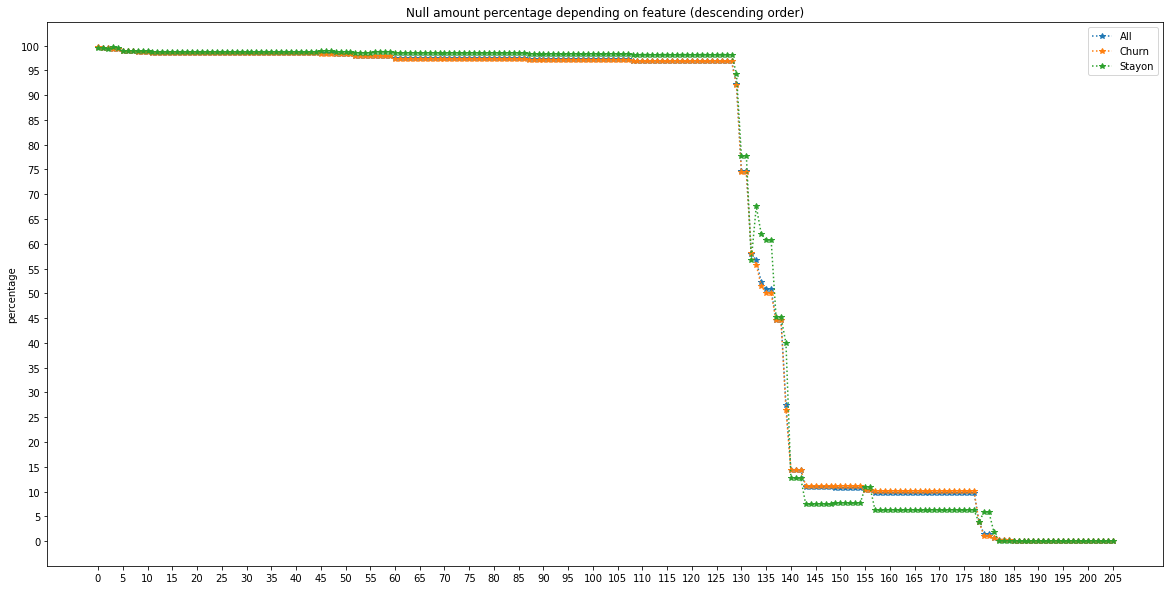

In [24]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

_len = len(null_perc_data)

ax.plot(range(_len), null_perc_data['All'], linestyle='dotted', marker='*', label='All')
ax.plot(range(_len) ,null_perc_data['Churn'], linestyle='dotted', marker='*', label='Churn')
ax.plot(range(_len) ,null_perc_data['Stayon'], linestyle='dotted', marker='*', label='Stayon')

ax.set_ylabel('percentage')
ax.set_title('Null amount percentage depending on feature (descending order)')
ax.legend()

ax.xaxis.set_major_locator(FixedLocator(np.arange(0, 210, 5)))
ax.yaxis.set_major_locator(FixedLocator(np.arange(0, 105, 5)))

In [25]:
# After null percentage 90.3% goes rapid decreasing to 74.6%. Next rapid decreasing is from 74.6 to 52.3
# It makes sence to consider null percentage threshold at 80% and 60%

In [26]:
# Transformer that deletes features with high null percentage (more than threshold)
# Saves remaining columns to self.real_features and self.cat_features

class NullPercentageThreshold(TransformerMixin, BaseEstimator):
    def __init__(self, threshold=100):
        self.threshold = threshold
    

    def fit(self, X, y=None):
        null_perc_stat = np.sum(X.isnull(), axis=0)/len(X)*100
        new_columns = null_perc_stat[null_perc_stat < self.threshold].index
        self.real_features, self.cat_features = get_real_cat_features(X.loc[:, new_columns]) 
        self.new_columns = new_columns
        return self
    
    
    def transform(self, X):
        return X.loc[:, self.new_columns]

## Raw run

In [97]:
null_perc_thrshld = NullPercentageThreshold(80).fit(data)
data_80 = null_perc_thrshld.transform(data)

real_features=null_perc_thrshld.real_features
cat_features=null_perc_thrshld.cat_features

In [98]:
null_compl_scaler = NullCompleterAndScaler(real_feats=real_features,
                                           cat_feats=cat_features,
                                           rfill='mean', scaler='standard')
null_compl_scaler.fit(data_80)
data_80_filled = null_compl_scaler.transform(data_80)

In [99]:
data_80_filled.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,0.758090,0.000000,-8.891795e-17,0.445697,0.449953,1.557011,1.920575,-0.269845,-0.261179,-0.870906,...,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,null,fKCe,02N6s8f,xwM2aC7IdeMC0,null
1,0.220730,0.035193,-2.383817e-01,-0.043751,-0.039065,-0.256271,0.158952,-0.646487,-0.261179,0.047921,...,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,ELof,xb3V,RAYp,55YFVY9,mj86
2,0.281449,0.035193,-3.119020e-01,-0.109498,-0.104754,-0.457746,-0.121307,0.988932,-0.261179,0.745845,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,null,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
3,0.099293,0.035193,-4.855350e-01,0.175405,0.179898,-0.457746,0.239026,-0.043680,1.543349,-0.597142,...,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,null,xb3V,RAYp,F2FyR07IdsN7I,null
4,-0.268055,0.035193,-4.870992e-01,-0.138719,-0.133949,-0.256271,-0.241417,0.608686,-0.261179,0.628897,...,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,null,WqMG,RAYp,F2FyR07IdsN7I,null


In [100]:
%%time

cv_params = {'random_seed': 19, 'eval_metric': 'AUC',
             'loss_function': 'Logloss','logging_level': 'Silent'}

cv_data = cv(
    Pool(data_80_filled, y, cat_features=list(cat_features)),
    cv_params,
    fold_count=4,
    early_stopping_rounds=50,
    plot=True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 1min 30s


In [139]:
cv_data['test-AUC-mean'].max()

0.7431252556695975

In [140]:
cv_data['test-AUC-mean'].argmax()

306

In [60]:
X_train, X_validate, y_train, y_validate = train_test_split(data_80_filled, y,
                                                            train_size=0.75, stratify=y)

In [93]:
%%time

catb_clf = CatBoostClassifier(eval_metric='AUC', random_seed=19)
catb_clf.fit(X_train, y_train,
             cat_features=list(cat_features),
             eval_set=(X_validate, y_validate),
             verbose=False,
             plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 1min 14s


## Choosing null percentage level

In [34]:
null_thresholds = [100, 80, 70, 60]

### with train-test split

In [125]:
%%time

null_perc_scores = {'perc_threshold': [],
                    'roc_auc_best': [],
                    'best_iter': []}

for null_threshold in null_thresholds:
    print(f'processing threshold {null_threshold}')
    null_perc_thr = NullPercentageThreshold(threshold=null_threshold)
    _data = null_perc_thr.fit_transform(data)
    _X_train, _X_validate, _y_train, _y_validate = train_test_split(_data, y,
                                                                    train_size=0.75, stratify=y)
    _real_features = list(null_perc_thr.real_features)
    _cat_features = list(null_perc_thr.cat_features)
    
    null_compl_scaler = NullCompleterAndScaler(_real_features, _cat_features,
                                               rfill='mean', scaler='standard')
    _X_train = null_compl_scaler.fit_transform(_X_train)
    _X_validate = null_compl_scaler.transform(_X_validate)
    
    catb_clf = CatBoostClassifier(eval_metric='AUC', random_seed=19)
    catb_clf.fit(_X_train, _y_train,
                 cat_features=_cat_features,
                 eval_set=(_X_validate, _y_validate),
                 verbose=False)
    null_perc_scores['perc_threshold'].append(null_threshold)
    null_perc_scores['roc_auc_best'].append(catb_clf.get_best_score()['validation']['AUC'])
    null_perc_scores['best_iter'].append(catb_clf.get_best_iteration())

processing threshold 100
processing threshold 80
processing threshold 70
processing threshold 60
Wall time: 4min 32s


In [127]:
pd.DataFrame(null_perc_scores)

,perc_threshold,roc_auc_best,best_iter
0,100,0.732908,305
1,80,0.723821,163
2,70,0.750292,153
3,60,0.737684,201


### with cross-validation

In [141]:
%%time

null_perc_scores = {'perc_threshold': [],
                    'roc_auc_best': [],
                    'best_iter': []}

for null_threshold in null_thresholds:
    print(f'processing threshold {null_threshold}')
    null_perc_thr = NullPercentageThreshold(threshold=null_threshold)
    _data = null_perc_thr.fit_transform(data)

    _real_features = list(null_perc_thr.real_features)
    _cat_features = list(null_perc_thr.cat_features)
    
    null_compl_scaler = NullCompleterAndScaler(_real_features, _cat_features,
                                               rfill='mean', scaler='standard')
    _data = null_compl_scaler.fit_transform(_data)
    
    cv_params = {'random_seed': 19, 'eval_metric': 'AUC',
                 'loss_function': 'Logloss','logging_level': 'Silent'}
    cv_data = cv(
        Pool(_data, y, cat_features=_cat_features),
        cv_params,
        fold_count=4,
        early_stopping_rounds=100,
    )

    null_perc_scores['perc_threshold'].append(null_threshold)
    null_perc_scores['roc_auc_best'].append(cv_data['test-AUC-mean'].max())
    null_perc_scores['best_iter'].append(cv_data['test-AUC-mean'].argmax())

processing threshold 100
processing threshold 80
processing threshold 70
processing threshold 60
Wall time: 10min


In [142]:
pd.DataFrame(null_perc_scores)

,perc_threshold,roc_auc_best,best_iter
0,100,0.745256,544
1,80,0.744686,764
2,70,0.746988,490
3,60,0.746988,490


In [72]:
# Both approaches shows that 70% threshold is the best

In [101]:
null_perc_thr = NullPercentageThreshold(threshold=70)
X = null_perc_thr.fit_transform(data)
real_features = list(null_perc_thr.real_features)
cat_features = list(null_perc_thr.cat_features)

## Choosing best completing and scaling

In [36]:
rfill_options = ['zero', 'mean', 'minus_inf']
scalers = [('standard', True), ('standard', False), ('minmax', None)] # second value in tuple is for 'with_mean' parameter

In [198]:
cv_params = {'random_seed': 19, 'eval_metric': 'AUC',
             'loss_function': 'Logloss','logging_level': 'Silent'}

completing_scaling_scores = {'rfill': [],
                             'scaler': [],
                             'roc_auc_mean': [],
                             'best_iter': []}
for rfill in rfill_options:
    for scaler, with_mean in scalers:
        print(f'processing {scaler} (with_mean={with_mean}) with rfill={rfill}')
        null_compl_scaler = NullCompleterAndScaler(real_features, cat_features,
                                                   rfill=rfill, scaler=scaler, with_mean=with_mean)
        _X = null_compl_scaler.fit_transform(X)
        cv_data = cv(
            Pool(_X, y, cat_features=cat_features),
            cv_params,
            fold_count=4,
            early_stopping_rounds=100,
        )
        scaler_name = scaler if with_mean is None else f'{scaler}_with_mean={with_mean}'
        completing_scaling_scores['rfill'].append(rfill)
        completing_scaling_scores['scaler'].append(scaler_name)
        completing_scaling_scores['roc_auc_mean'].append(cv_data['test-AUC-mean'].max())
        completing_scaling_scores['best_iter'].append(cv_data['test-AUC-mean'].argmax())

processing standard (with_mean=True) with rfill=zero
processing standard (with_mean=False) with rfill=zero
processing minmax (with_mean=None) with rfill=zero
processing standard (with_mean=True) with rfill=mean
processing standard (with_mean=False) with rfill=mean
processing minmax (with_mean=None) with rfill=mean
processing standard (with_mean=True) with rfill=minus_inf
processing standard (with_mean=False) with rfill=minus_inf
processing minmax (with_mean=None) with rfill=minus_inf


In [199]:
pd.DataFrame(completing_scaling_scores)

,rfill,scaler,roc_auc_mean,best_iter
0,zero,standard_with_mean=True,0.742262,435
1,zero,standard_with_mean=False,0.742260,435
2,zero,minmax,0.742995,437
3,mean,standard_with_mean=True,0.746988,490
4,mean,standard_with_mean=False,0.746712,490
5,mean,minmax,0.746713,490
6,minus_inf,standard_with_mean=True,0.739428,982
7,minus_inf,standard_with_mean=False,0.739429,982
8,minus_inf,minmax,0.737968,435


In [88]:
# So let's choose Standard scaling with mean fillng

In [103]:
null_compl_scaler = NullCompleterAndScaler(real_features, cat_features,
                                           rfill='mean', scaler='standard')

In [104]:
X = null_compl_scaler.fit_transform(X)

In [105]:
X

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,0.758090,0.000000,-8.891795e-17,0.445697,0.449953,1.557011,1.920575,-0.269845,-0.261179,-0.870906,...,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,null,fKCe,02N6s8f,xwM2aC7IdeMC0,null
1,0.220730,0.035193,-2.383817e-01,-0.043751,-0.039065,-0.256271,0.158952,-0.646487,-0.261179,0.047921,...,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,ELof,xb3V,RAYp,55YFVY9,mj86
2,0.281449,0.035193,-3.119020e-01,-0.109498,-0.104754,-0.457746,-0.121307,0.988932,-0.261179,0.745845,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,null,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
3,0.099293,0.035193,-4.855350e-01,0.175405,0.179898,-0.457746,0.239026,-0.043680,1.543349,-0.597142,...,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,null,xb3V,RAYp,F2FyR07IdsN7I,null
4,-0.268055,0.035193,-4.870992e-01,-0.138719,-0.133949,-0.256271,-0.241417,0.608686,-0.261179,0.628897,...,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,null,WqMG,RAYp,F2FyR07IdsN7I,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18293,1.122402,-1.144308,-4.870992e-01,2.337746,2.340333,1.154060,1.560243,-0.420322,-0.261179,-0.019784,...,null,fmK1UQz,oslk,LsdaF5M,null,null,Xa3G,RAYp,F2FyR07IdsN7I,null
18294,-0.365205,-1.144308,-4.870992e-01,0.591801,0.595928,0.348157,0.679432,-0.420322,-0.261179,1.363051,...,FzaX,25cNqhB,oslk,mErwEWL,LM8l689qOp,null,uWr3,RAYp,F2FyR07IdsN7I,null
18295,0.129652,0.035193,2.543605e-01,-0.146024,-0.141247,-0.054795,-0.401565,-1.023129,-0.261179,-0.886174,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c
18296,-0.028216,0.035193,1.294594e+00,-0.131414,-0.126650,0.348157,-0.361528,1.500733,-0.261179,-0.779492,...,FzaX,4UxGlow,oslk,catzS2D,LM8l689qOp,ELof,Qcbd,ZI9m,55YFVY9,am7c


In [118]:
%%time

cv_params = {'random_seed': 19, 'eval_metric': 'AUC',
             'loss_function': 'Logloss','logging_level': 'Silent'}

cv_data1 = cv(
    Pool(X, y, cat_features=cat_features),
    cv_params,
    fold_count=4,
    early_stopping_rounds=150,
    stratified=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 37s


In [119]:
cv_data1['test-AUC-mean'].max()

0.7464648494986902

In [108]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.500000,0.000000,0.661889,0.000002,0.661889,0.000008
1,1,0.551612,0.020511,0.632594,0.000119,0.632610,0.000087
2,2,0.586463,0.018016,0.605433,0.000165,0.605443,0.000117
3,3,0.601188,0.047780,0.580242,0.000865,0.580216,0.000936
4,4,0.606292,0.044846,0.557042,0.000803,0.556992,0.000916
...,...,...,...,...,...,...,...
586,586,0.746754,0.017102,0.238437,0.002225,0.208258,0.008921
587,587,0.746754,0.017102,0.238438,0.002225,0.208256,0.008924
588,588,0.746760,0.017093,0.238437,0.002224,0.208228,0.008959
589,589,0.746766,0.017084,0.238433,0.002220,0.208217,0.008973


In [109]:
cv_data['test-AUC-mean'].max()

0.7469877971307574

In [120]:
y_ = y.copy()
y_[y_==-1] = 0.

In [121]:
Counter(y_)

Counter({0.0: 16921, 1.0: 1377})

In [122]:
%%time

cv_params = {'random_seed': 19, 'eval_metric': 'AUC',
             'loss_function': 'CrossEntropy','logging_level': 'Silent'}

cv_data2 = cv(
    Pool(X, y_, cat_features=list(cat_features)),
    cv_params,
    fold_count=4,
    early_stopping_rounds=150,
    stratified=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 38s


In [123]:
cv_data2['test-AUC-mean'].max()

0.7464648494986902

# Parameters tuning

In [171]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.75,
                                                            stratify=y, shuffle=True, random_state=19)

In [217]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_validate, y_validate, cat_features=cat_features)
cv_pool = Pool(X, y, cat_features=cat_features)

In [218]:
params = {'random_seed': 19, 'eval_metric': 'AUC', 'iterations': 1000,
          'loss_function': 'Logloss', 'verbose': 500}

In [262]:
grid = {
    'learning_rate': np.arange(0.001, 0.07, 0.01)
}

In [263]:
catb_clf = CatBoostClassifier(**params)

In [264]:
grid_search_results = catb_clf.grid_search(grid, cv_pool, shuffle=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5568853	best: 0.5568853 (0)	total: 44.7ms	remaining: 44.7s
500:	test: 0.6754109	best: 0.6754109 (499)	total: 22s	remaining: 21.9s
999:	test: 0.6963899	best: 0.6965633 (997)	total: 44.6s	remaining: 0us

bestTest = 0.6965633244
bestIteration = 997

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6965633	best: 0.6965633 (0)	total: 44.7s	remaining: 4m 28s
0:	test: 0.5568853	best: 0.5568853 (0)	total: 48.6ms	remaining: 48.6s
500:	test: 0.7456273	best: 0.7457012 (498)	total: 29.6s	remaining: 29.5s
999:	test: 0.7497548	best: 0.7498929 (998)	total: 1m 2s	remaining: 0us

bestTest = 0.7498929318
bestIteration = 998

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7498929	best: 0.7498929 (1)	total: 1m 46s	remaining: 4m 26s
0:	test: 0.5568853	best: 0.5568853 (0)	total: 38.2ms	remaining: 38.2s
500

In [266]:
grid = {
    'learning_rate': np.arange(0.06, 0.11, 0.01)
}

grid_search_results1 = CatBoostClassifier(**params).grid_search(grid, cv_pool, shuffle=False, plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5568853	best: 0.5568853 (0)	total: 84.1ms	remaining: 1m 23s
500:	test: 0.7393585	best: 0.7430855 (123)	total: 33.6s	remaining: 33.5s
999:	test: 0.7319429	best: 0.7430855 (123)	total: 1m 7s	remaining: 0us

bestTest = 0.7430855347
bestIteration = 123

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7430855	best: 0.7430855 (0)	total: 1m 7s	remaining: 4m 28s
0:	test: 0.5568853	best: 0.5568853 (0)	total: 53.7ms	remaining: 53.7s
500:	test: 0.7337117	best: 0.7533619 (120)	total: 33.6s	remaining: 33.5s
999:	test: 0.7282652	best: 0.7533619 (120)	total: 1m 7s	remaining: 0us

bestTest = 0.753361942
bestIteration = 120

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7533619	best: 0.7533619 (1)	total: 2m 14s	remaining: 3m 22s
0:	test: 0.5568853	best: 0.5568853 (0)	total: 42.6ms	remaining: 42.5s
5

In [268]:
grid_search_results1['params']

{'learning_rate': 0.06999999999999999}

In [282]:
pd.DataFrame(grid_search_results['cv_results'])['test-AUC-mean']

0      0.494565
1      0.499649
2      0.520035
3      0.533328
4      0.539453
         ...   
995    0.740421
996    0.740427
997    0.740449
998    0.740438
999    0.740417
Name: test-AUC-mean, Length: 1000, dtype: float64

In [274]:
params.update(grid_search_results1['params'])

In [276]:
cv_data = cv(
    cv_pool,
    params,
    fold_count=4,
    early_stopping_rounds=150,
    stratified=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.95ms	remaining: 9.94s

bestTest = 0.7617461182
bestIteration = 119

Training on fold [1/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 20.8ms	remaining: 20.8s

bestTest = 0.7285708395
bestIteration = 238

Training on fold [2/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.46ms	remaining: 8.45s
500:	test: 0.7320730	best: 0.7323135 (458)	total: 37s	remaining: 36.8s

bestTest = 0.7325911265
bestIteration = 593

Training on fold [3/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.01ms	remaining: 9s

bestTest = 0.7619756446
bestIteration = 118



In [283]:
params

{'random_seed': 19,
 'eval_metric': 'AUC',
 'iterations': 1000,
 'loss_function': 'Logloss',
 'verbose': 500,
 'depth': 6,
 'l2_leaf_reg': 3,
 'learning_rate': 0.06999999999999999}

In [284]:
catb_model = CatBoostClassifier(**params)

In [287]:
catb_model.fit(X_train, y_train, cat_features=cat_features,
               eval_set=(X_validate, y_validate),  use_best_model=True)

0:	test: 0.5391916	best: 0.5391916 (0)	total: 57.6ms	remaining: 57.6s
500:	test: 0.7542529	best: 0.7683344 (169)	total: 29.5s	remaining: 29.4s
999:	test: 0.7341782	best: 0.7683344 (169)	total: 60s	remaining: 0us

bestTest = 0.7683343594
bestIteration = 169

Shrink model to first 170 iterations.


# Submitting

In [295]:
raw_test_data = pd.read_csv('orange_small_churn_test_data.csv', header=0)

In [303]:
test_data_ = raw_test_data.loc[:, real_features+cat_features]

In [308]:
test_data = null_compl_scaler.transform(test_data_)
test_data.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,-0.034288,0.035193,0.432686,-0.102193,-0.097455,-0.457746,-0.201380,1.848541,-0.261179,1.456209,...,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,ELof,xb3V,6fzt,Zy3gnGM,null
1,-0.176977,1.214693,0.122963,-0.226382,-0.221534,-0.457746,-0.001196,-1.023129,-0.261179,-0.899890,...,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,null,xb3V,RAYp,F2FyR07IdsN7I,null
2,-0.222516,0.035193,0.617269,-0.116804,-0.112052,-0.054795,-0.401565,1.132200,-0.261179,0.146819,...,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86
3,0.430210,0.035193,0.972356,0.445697,0.449953,0.549632,0.038841,0.709604,-0.261179,1.424960,...,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c
4,0.021001,0.014786,0.008967,0.002056,0.003766,-0.003898,0.014918,0.015372,0.007287,0.009550,...,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,null,7P5s,RAYp,F2FyR07IdsN7I,null


In [310]:
predictions = catb_model.predict_proba(test_data)[:, 1]

In [312]:
tosubmit = pd.DataFrame({'Id': list(range(len(predictions))), 'result': predictions})
tosubmit.head()

,Id,result
0,0,0.093730
1,1,0.116361
2,2,0.024552
3,3,0.058094
4,4,0.025057


In [313]:
tosubmit.to_csv('submission_catboost.csv', index=False)

**Final evaluation** on kaggle gives ROC AUC score `0.722`. It is better than the other `75%` of participants